# USA Rain Prediction (2024 - 2025)

## 1. Problem
> Predict whether a specific day will experience rain or not.

## 2. Dataset 
This dataset provides comprehensive weather data collected from 20 major cities across the USA during the years 2024 and 2025. 🌍 It contains a variety of weather attributes that are crucial for predicting whether it will rain the next day or not. With over 2 years of daily data, this dataset serves as a perfect starting point for building predictive models, analyzing weather trends, or even developing weather-related applications. 📊

Each row represents a single day's weather conditions, including important features like temperature, humidity, wind speed, cloud cover, atmospheric pressure, and precipitation. The target feature, "Rain Tomorrow," is a binary label (1 = Yes, 0 = No) indicating whether it rained the next day. ☔

## 3. Evaluation 
We will us the following evaluation metrics: 
- Classification Report
- Confusion Matrix 
- Accuracy Score

## 4. Features
- Date 
- temperature 
- humidity
- wind speed 
- cloud cover 
- atmospheric pressure 
- Precipitation 
- The target feature, `"Rain Tomorrow"` is a binary label (1 = Yes, 0 = No)

## Preparing the tools

In [5]:
import numpy as np
import pandas as pd
import missingno as msno
from datetime import datetime

# Import the Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# IMport the models, Data Pre-Processing tools and more 
import optuna
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [34]:
df = pd.read_csv("usa_rain.csv")
df.head()

,Date,Location,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow
0,2024-01-01,New York,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0
1,2024-01-02,New York,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0
2,2024-01-03,New York,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1
3,2024-01-04,New York,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0
4,2024-01-05,New York,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0


In [35]:
print("Number of Columns:", df.shape[1])
print("Number of Rows:", df.shape[0])

Number of Columns: 9
Number of Rows: 73100


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           73100 non-null  object 
 1   Location       73100 non-null  object 
 2   Temperature    73100 non-null  float64
 3   Humidity       73100 non-null  float64
 4   Wind Speed     73100 non-null  float64
 5   Precipitation  73100 non-null  float64
 6   Cloud Cover    73100 non-null  float64
 7   Pressure       73100 non-null  float64
 8   Rain Tomorrow  73100 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.0+ MB


<Axes: >

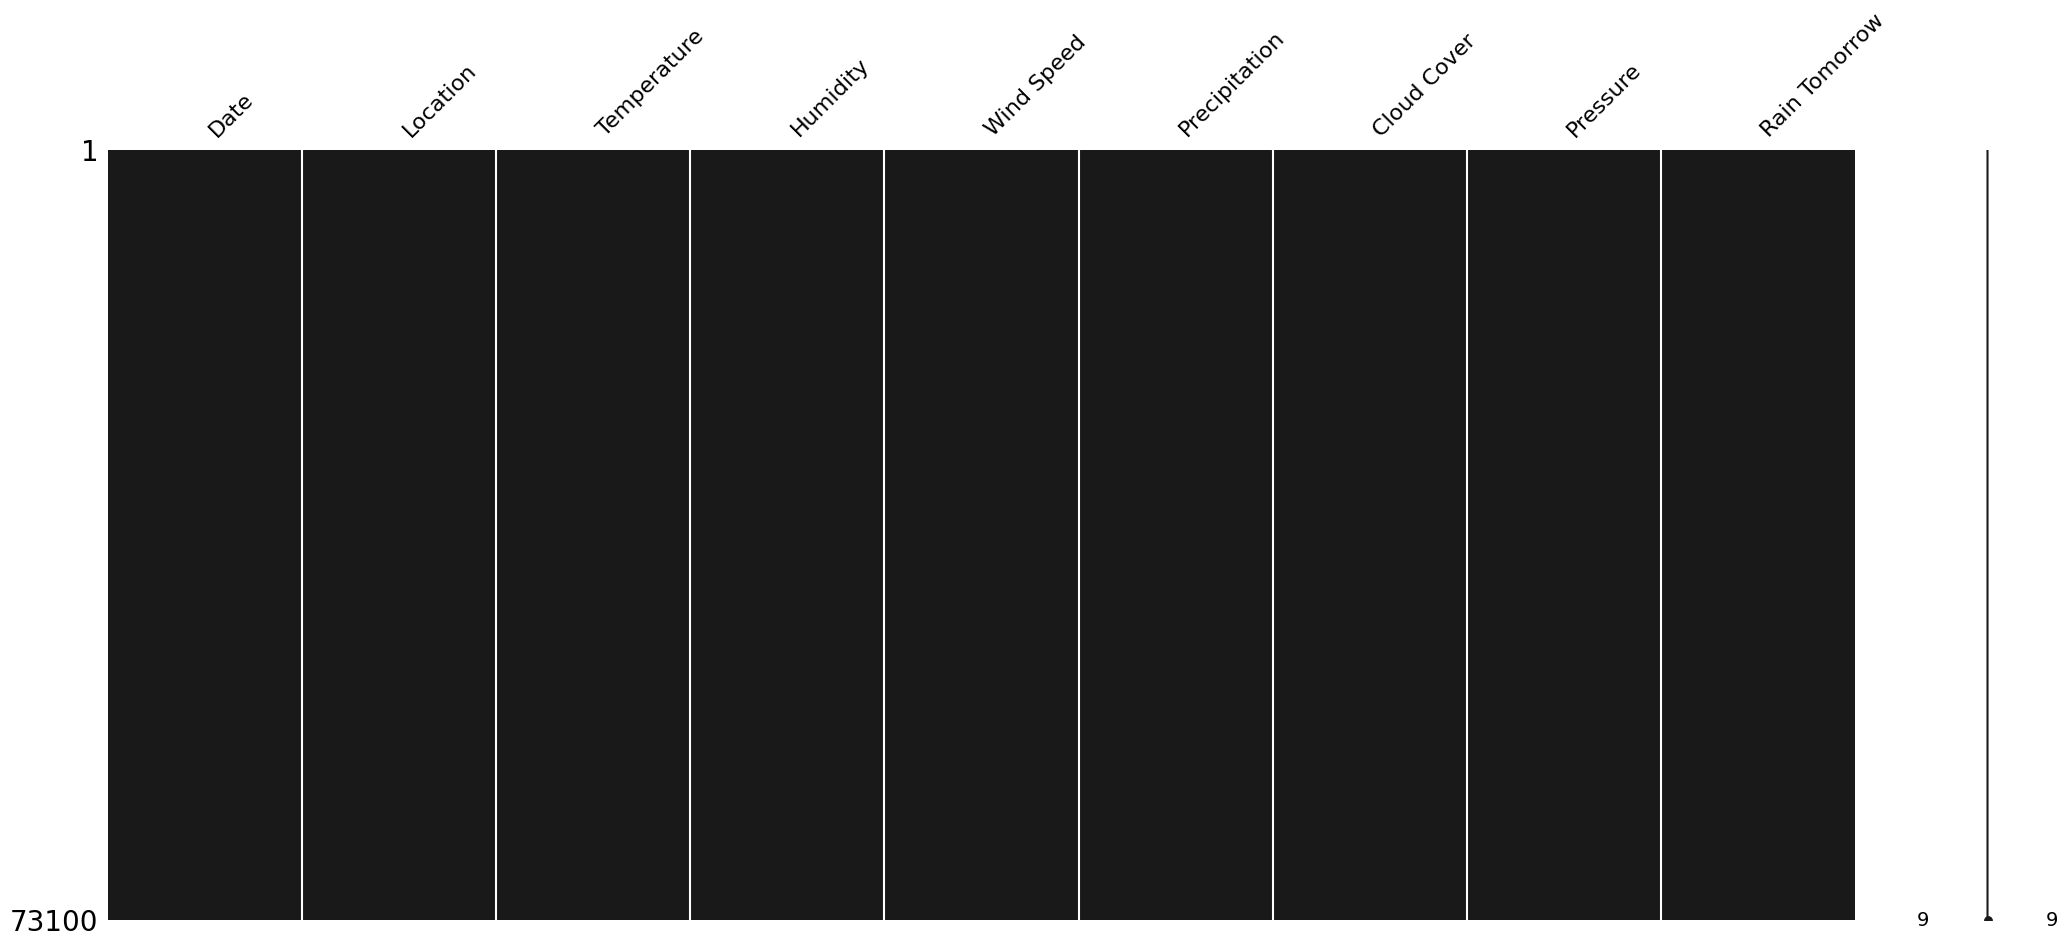

In [37]:
msno.matrix(df, color=(0.1, 0.1, 0.1))

In [38]:
df.isna().sum()

Date             0
Location         0
Temperature      0
Humidity         0
Wind Speed       0
Precipitation    0
Cloud Cover      0
Pressure         0
Rain Tomorrow    0
dtype: int64

In [39]:
# Check for duplicates
print("Number of Duplicates:", df.duplicated().sum())

Number of Duplicates: 0


## Exploratory Data Analysis (EDA)
let's do some EDA and uncover some patterns

In [40]:
des = df.describe().transpose()
des.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Temperature,73100.000000,65.182270,20.205793,30.000766,47.678968,65.294949,82.636570,99.997393
Humidity,73100.000000,59.875041,23.066115,20.000272,39.800732,59.887840,79.835990,99.999025
Wind Speed,73100.000000,15.017946,8.668729,0.000712,7.485182,15.102495,22.551794,29.999017
Precipitation,73100.000000,0.390635,0.474833,0.000000,0.000000,0.196909,0.673177,3.078090
Cloud Cover,73100.000000,54.942807,25.982487,10.000856,32.318668,55.011121,77.412469,99.998957
Pressure,73100.000000,1005.176013,20.203889,970.000919,987.697646,1005.284188,1022.727410,1039.999765
Rain Tomorrow,73100.000000,0.220410,0.414526,0.000000,0.000000,0.000000,0.000000,1.000000


In the above the code, The `gradient` highlights certain areas, with `darker blue` indicating `higher or lower values`. For example, the standard deviation for `Wind Speed (8.66)` is highlighted because it's much larger compared to `Temperature (20.2)`.

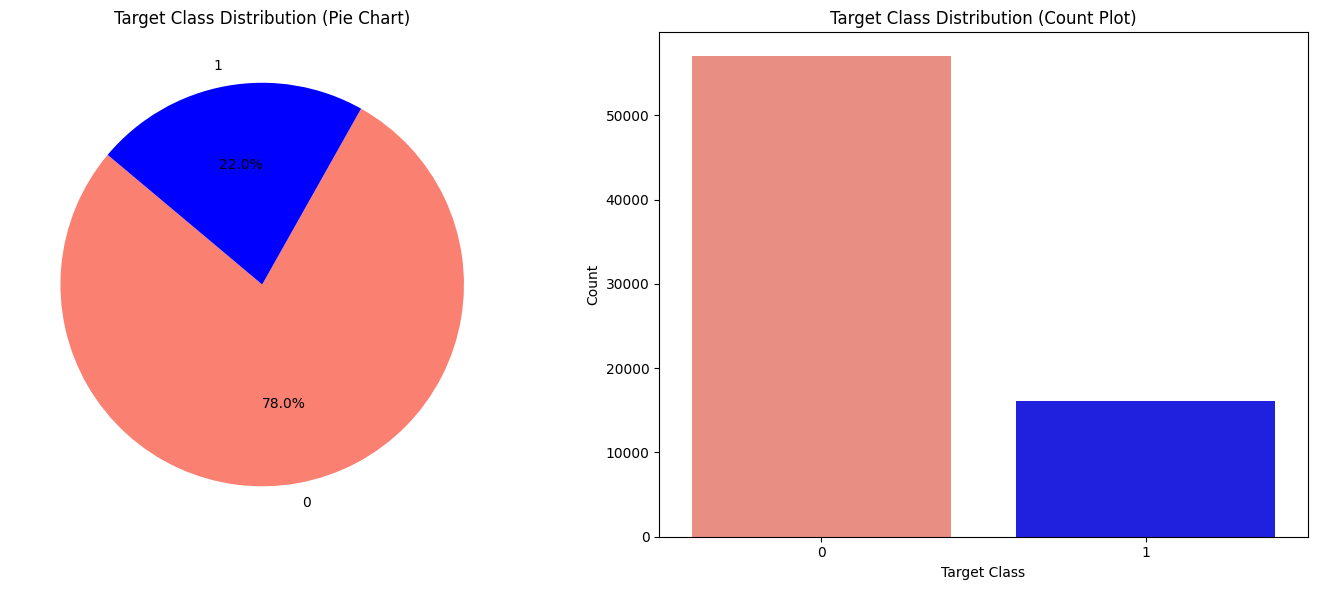

In [41]:
# Visualize the target Feature
target_counts = df["Rain Tomorrow"].value_counts().sort_index()

palette = sns.color_palette("bright", n_colors=len(target_counts))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140, colors=['Salmon','Blue'])
ax1.set_title('Target Class Distribution (Pie Chart)')
sns.countplot(x="Rain Tomorrow", data=df, ax=ax2, order=target_counts.index, palette=['Salmon','Blue'])
ax2.set_title('Target Class Distribution (Count Plot)')
ax2.set_xlabel('Target Class')
ax2.set_ylabel('Count')
plt.tight_layout()
plt.show()

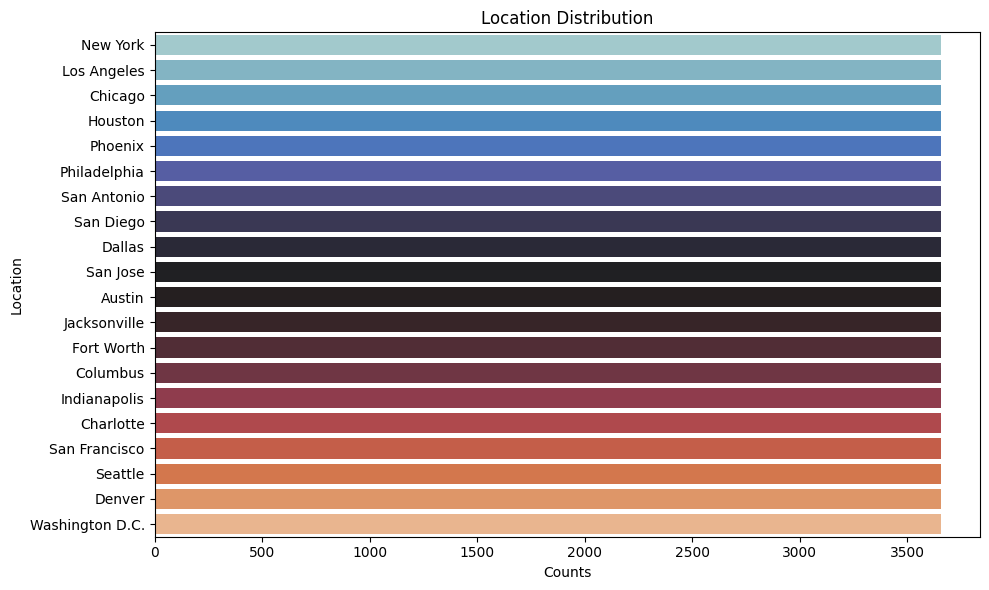

In [42]:
# Visualize the location
location_counts = df["Location"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette="icefire")
plt.title("Location Distribution")
plt.xlabel("Counts")
plt.ylabel("Location")
plt.tight_layout()

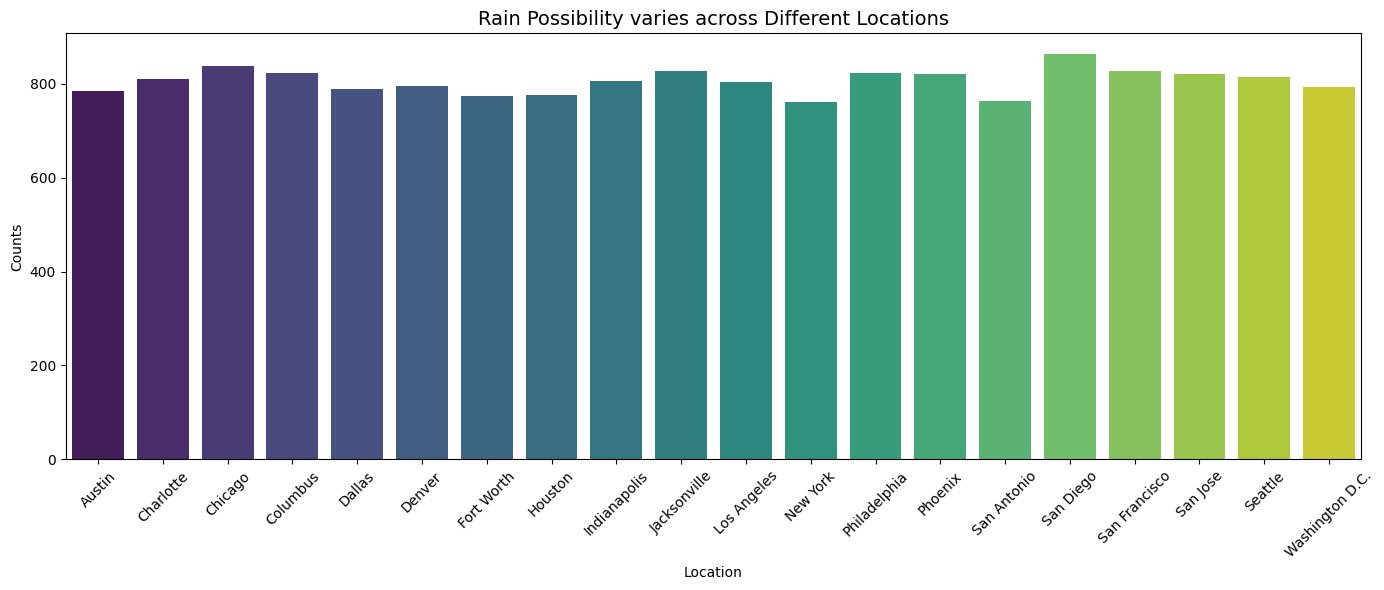

In [43]:
# Check for rain possibility in every location
rain_by_location = df.groupby("Location")["Rain Tomorrow"].sum()

plt.figure(figsize=(14, 6))
sns.barplot(x=rain_by_location.index, y=rain_by_location.values, palette="viridis")
plt.title("Rain Possibility varies across Different Locations", fontsize=14)
plt.xlabel("Location")
plt.xticks(rotation=45)
plt.ylabel("Counts")
plt.tight_layout()

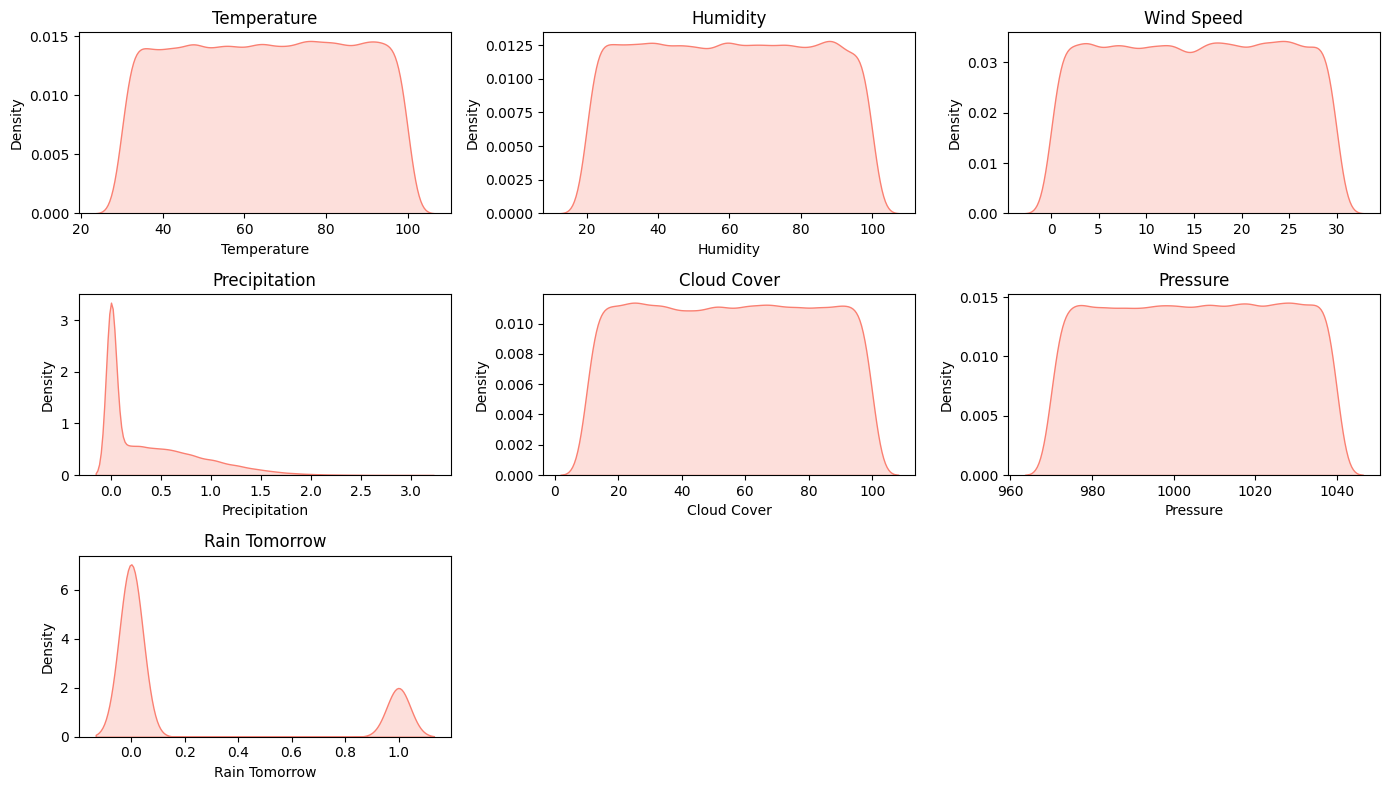

In [44]:
plt.figure(figsize=(14, 8))
for i, feature in enumerate(df.select_dtypes(include="number").columns):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(data=df, x=feature, fill=True, color='salmon')
    plt.title(f"{feature}")
plt.tight_layout()

Here's the explanation of the above visualization:
- The `flat KDE` plots for most features `(Temperature, Humidity, etc.)` suggest the data is `fairly uniformly distributed` across the feature ranges.
- The `sharp peak` for `Precipitation` indicates that the dataset contains many instances of `no or low precipitation`, while higher values are rare.
- The `bimodal distribution` for `Rain Tomorrow` confirms that this feature likely represents a `binary outcome`, with most instances having no rain.

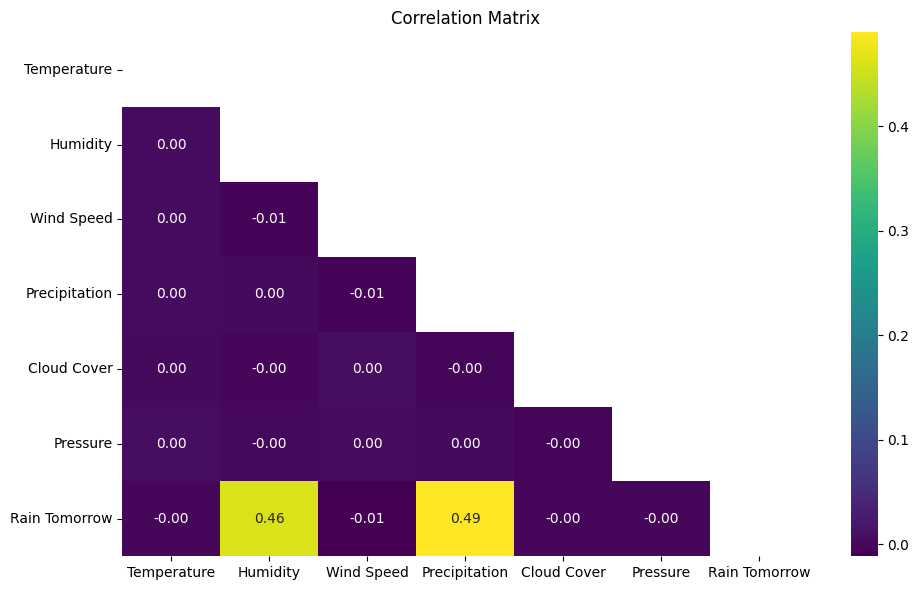

In [45]:
corr = df.select_dtypes(include="number").corr()
mask_ut = np.triu(np.ones(corr.shape)).astype(np.bool_)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", mask=mask_ut)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

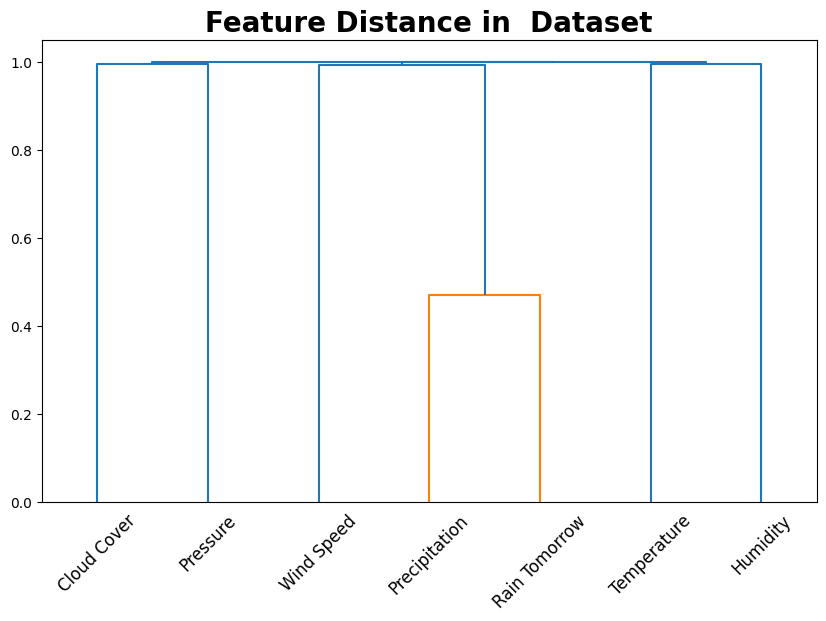

In [46]:
# Create a function to check the feature the distance
def distance(data, label = ''):
    corr = data.corr(method = 'spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')
    
    plt.figure(figsize = (10, 6), dpi = 100)
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=45)
    plt.title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 20)
    plt.show()

distance(df.select_dtypes(include="number"))

## Treating the Outliers

**We can clearly see that the outliers are present in our dataset. SO, we are going to treat it and make our dataset outlier free.**

In [47]:
q1 = df["Precipitation"].quantile(0.25)
q3 = df["Precipitation"].quantile(0.75)
iqr = q3 - q1

upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

df = df.loc[(df["Precipitation"] < upper_limit) & (df["Precipitation"] > lower_limit)]

In [48]:
df.shape

(71908, 9)

## Feature Engineering

We are going to transform our `categorical data` into `numerical data` and some more features to help get more better accuracy.


In [49]:
# First Add more features in the dataset
df['Temp_Humidity_Interaction'] = df['Temperature'] * df['Humidity']
df['Wind_Cloud_Ratio'] = df['Wind Speed'] / df['Cloud Cover']
df['Date'] = pd.to_datetime(df['Date'])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

In [50]:
# Now change the categorical data into numerical data
encoder = LabelEncoder()
df["Location"] = encoder.fit_transform(df["Location"])

In [51]:
df.head()

,Date,Location,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow,Temp_Humidity_Interaction,Wind_Cloud_Ratio,Year,Month,Day
0,2024-01-01,11,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0,6621.728203,0.407646,2024,1,1
1,2024-01-02,11,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0,2390.593142,0.298909,2024,1,2
2,2024-01-03,11,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1,5240.256547,0.183350,2024,1,3
3,2024-01-04,11,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0,4665.468416,0.370072,2024,1,4
4,2024-01-05,11,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0,1288.455717,0.043112,2024,1,5


## Split the dataset into training and test sets

In [52]:
X = df.drop(["Date", "Rain Tomorrow"], axis=1)
y = df["Rain Tomorrow"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((57526, 12), (14382, 12), (57526,), (14382,))

## Construction of multiple Models

let's construct our models which includes the tuning of the parameters as well and finishing with an accuracy, then compare the models.

In [54]:
# with RandomForestClassifier
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    model = RandomForestClassifier(**param, random_state=42, n_jobs=-1)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=5)

print("Best RandomForest Params:", study_rf.best_params)
print("Best RandomForest Accuracy:", study_rf.best_value)

[I 2024-10-12 15:41:32,588] A new study created in memory with name: no-name-704707fb-468e-4e80-9053-2769731de2e5
[I 2024-10-12 15:41:41,056] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 738, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 0 with value: 1.0.
[I 2024-10-12 15:41:45,847] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 427, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 0 with value: 1.0.
[I 2024-10-12 15:41:48,508] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 141, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 0 with value: 1.0.
[I 2024-10-12 15:41:51,401] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 244, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 11, 'bootstrap': True}. Best is trial 0 with value: 1.0.
[I 2024-10-12 15:4

Best RandomForest Params: {'n_estimators': 738, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': True}
Best RandomForest Accuracy: 1.0


In [55]:
# with KNN
def objective_knn(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2), 
    }
    
    model = KNeighborsClassifier(**param)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=20)

print("Best KNN Params:", study_knn.best_params)
print("Best KNN Accuracy:", study_knn.best_value)

[I 2024-10-12 15:44:48,813] A new study created in memory with name: no-name-279f41f2-548b-46e1-a93b-2a5c606fa1ed
[I 2024-10-12 15:44:49,378] Trial 0 finished with value: 0.7670699485467946 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.7670699485467946.
[I 2024-10-12 15:44:50,356] Trial 1 finished with value: 0.7641496314837992 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.7670699485467946.
[I 2024-10-12 15:44:51,071] Trial 2 finished with value: 0.7806285634821304 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.7806285634821304.
[I 2024-10-12 15:44:52,077] Trial 3 finished with value: 0.7768738701154221 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.7806285634821304.
[I 2024-10-12 15:44:52,720] Trial 4 finished with value: 0.7784035600055625 and parameters: {'n_neighbors': 13, 'weights': 

Best KNN Params: {'n_neighbors': 10, 'weights': 'uniform', 'p': 1}
Best KNN Accuracy: 0.7847309136420526


In [57]:
# with XGBoost
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 1e-1, log=True),
        'lambda': trial.suggest_float('lambda', 1e-3, 1e-1, log=True),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**param)
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose=False)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

print("Best XGB Params:", study_xgb.best_params)
print("Best XGB Accuracy:", study_xgb.best_value)

[I 2024-10-12 15:45:45,052] A new study created in memory with name: no-name-6d7c2750-49d3-4163-9df0-b62b1ebb73db
[I 2024-10-12 15:45:48,014] Trial 0 finished with value: 0.9990265609790016 and parameters: {'n_estimators': 888, 'max_depth': 6, 'learning_rate': 0.07533061727943999, 'colsample_bytree': 0.9231804082231236, 'subsample': 0.9266006193297809, 'alpha': 0.009804180659130272, 'lambda': 0.029319995857787322}. Best is trial 0 with value: 0.9990265609790016.
[I 2024-10-12 15:45:51,380] Trial 1 finished with value: 0.9990265609790016 and parameters: {'n_estimators': 955, 'max_depth': 10, 'learning_rate': 0.07168366955044765, 'colsample_bytree': 0.7143117761555132, 'subsample': 0.5452397346560888, 'alpha': 0.020344591647945963, 'lambda': 0.0015786289446699324}. Best is trial 0 with value: 0.9990265609790016.
[I 2024-10-12 15:45:55,415] Trial 2 finished with value: 0.9990265609790016 and parameters: {'n_estimators': 755, 'max_depth': 10, 'learning_rate': 0.005732924979286446, 'colsamp

Best XGB Params: {'n_estimators': 678, 'max_depth': 3, 'learning_rate': 0.0015918013305735194, 'colsample_bytree': 0.9960021713724818, 'subsample': 0.7667494170953426, 'alpha': 0.03378860683550776, 'lambda': 0.04707200624026243}
Best XGB Accuracy: 0.9993046864135725


In [59]:
params = {
    'n_estimators': 513, 
    'max_depth': 17, 
    'min_samples_split': 3, 
    'min_samples_leaf': 11, 
    'bootstrap': False
}

final_model = RandomForestClassifier(**params, n_jobs=-1)
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=17, min_samples_leaf=11,
                       min_samples_split=3, n_estimators=513, n_jobs=-1)

## Save the Preprocessed Data

In [74]:
df.to_csv('updated_usa_rain.csv', index=False)


,Date,Location,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow,Temp_Humidity_Interaction,Wind_Cloud_Ratio,Year,Month,Day
0,2024-01-01,11,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0,6621.728203,0.407646,2024,1,1
1,2024-01-02,11,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0,2390.593142,0.298909,2024,1,2
2,2024-01-03,11,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1,5240.256547,0.183350,2024,1,3
3,2024-01-04,11,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0,4665.468416,0.370072,2024,1,4
4,2024-01-05,11,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0,1288.455717,0.043112,2024,1,5


## Save the model

In [71]:
import pickle
model = final_model  # replace this with your trained model

# Create a dictionary to hold necessary tools

# Save the dictionary into a .pkl file
with open('final.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Tools saved successfully to 'final.pkl'.")

Tools saved successfully to 'final.pkl'.


## Evaluation

**Since the Random forest classifier did will in accuracy we will evaluate it.**

In [61]:
y_pred = final_model.predict(X_test)

print(f"Accuracy Score is: {(accuracy_score(y_test, y_pred) * 100):0.2f}")

Accuracy Score is: 100.00


In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11285
           1       1.00      1.00      1.00      3097

    accuracy                           1.00     14382
   macro avg       1.00      1.00      1.00     14382
weighted avg       1.00      1.00      1.00     14382



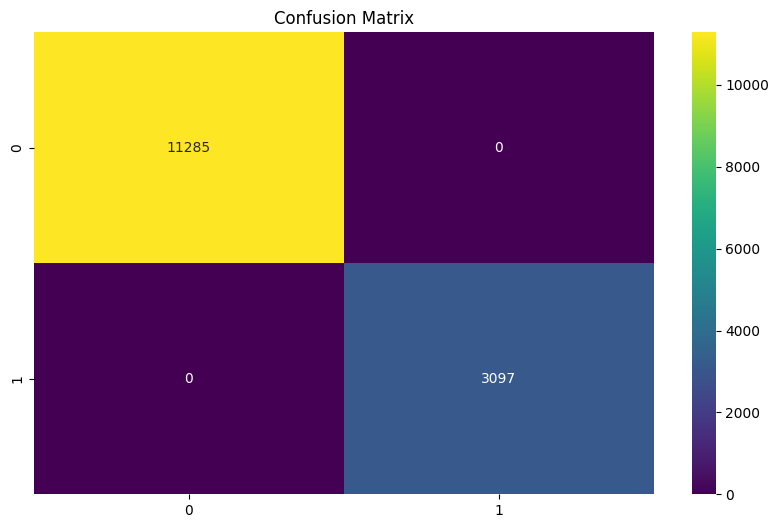

In [63]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix")
plt.show()